In [1]:
from collections import Counter, namedtuple
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR, SVR
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

TRAIN_FILE = './data/train_clean.csv'
TEST_FILE = './data/test_clean.csv'
FEATURES = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']
TARGETS = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
RANDOM_STATE = 42


def feature_to_target(feature):
    return feature[:-4] # drop '_sim' suffix


def target_to_feature(target):
    assert not target.endswith('_sim'), '{} is a feature already'.format(target)
    return target + '_sim'

$$SMAPE_s = \frac{1}{T_s} \sum_{t=1}^{T_s} \sum_{i=1}^{6} \frac{|p_{sti} - r_{sti}|}{|p_{sti}| + |r_{sti}|}$$
Where:
* $T_s$ -- number of measurements (timestamps) for satellite s
* $S$ -- total number of satellites
* $6$ -- total number of measured values (x, y, z, Vx, Vy, Vz) 
* $p_{sti}$ -- predicted value #$i$ of satellite $s$ in timestamp $t$
* $r_{sti}$ -- real value #$i$ of satellite $s$ in timestamp $t$

There're could be anomalies in data: too small time deltas between measurements. So, we need to filter out such measurements, cause I dunno how to use such signals (at least for now).

In [2]:
def load_data():
    def _sort_df(df):
        df.sort_values(by=['sat_id', 'epoch'], ascending=[True, True], inplace=True)
    
    def _find_anomalies(df, anomaly_threshold=10):
        epoch_diff = df.epoch.values[1:] - df.epoch.values[:-1]
        diff_counter = Counter(epoch_diff)
        anomaly_mask = np.full(df.shape[0] - 1, True, dtype=np.bool)
        for diff, count in diff_counter.items():
            if count > anomaly_threshold:
                continue
            anomaly_mask = np.logical_xor(anomaly_mask, epoch_diff == diff)
        return np.hstack([[True], anomaly_mask])
    
    def _load_data_frame(path, filter_anomalies=False):
        result = pd.read_csv(path, parse_dates=['epoch'])
        _sort_df(result)
        if filter_anomalies:
            anomalies = np.array([], dtype=np.bool)
            for _, df in result.groupby('sat_id'):
                sat_anomalies = _find_anomalies(df)
                anomalies = np.hstack([anomalies, sat_anomalies])
            result = result[anomalies]
        result.reset_index(drop=True, inplace=True)
        return result
    
    return _load_data_frame(TRAIN_FILE, False), _load_data_frame(TEST_FILE, False)


def calculate_score(df):
    def _calc_smape(lhs, rhs):
        return np.mean(np.abs((lhs - rhs) / (np.abs(lhs) + np.abs(rhs))))
    
    def _calc_score(smapes):
        return 100 * (1 - np.mean(smapes))
    
    per_sat_scores = []
    for _, data in df.groupby('sat_id'):
        smapes = _calc_smape(data[FEATURES].values, data[TARGETS].values)
        per_sat_scores.append(smapes)
    return _calc_score(per_sat_scores)

In [3]:
train_df, test_df = load_data()
train_df.head(3)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


# Training
NOTE: $84.90976860742092$ is initial score, it's stupid to submit worse results.

In [35]:
SatelliteTrainingData = namedtuple('SatelliteTrainingData', [
    'train_samples',
    'train_targets',
    'train_targets_shift',

    'test_samples',
    'test_targets',

    'scaler',
])


def prepare_val_data(train_df, test_df, window_size, test_fraction=0.15):
    test_sat_ids = set(test_df.sat_id.values)
    n_features = window_size + 1
    def _allocate_data(n_samples):
        return np.zeros((n_samples, n_features), dtype=np.float32), np.zeros(n_samples, dtype=np.float32)
        #return np.zeros((n_samples, n_features + 1), dtype=np.float32), np.zeros(n_samples, dtype=np.float32)
    
    val_data = dict()
    for sat_id, df in train_df.groupby('sat_id'):
        #if sat_id not in test_sat_ids:
        #    continue
        n_measurements = df.shape[0] - window_size
        test_size = int(round(n_measurements * test_fraction))
        train_size = n_measurements - test_size
        per_target_data = dict()
        train_targets_shift = []
        for feature in FEATURES:
            target = feature_to_target(feature)
            values = df[feature].values
            targets = df[target].values
            train_samples, train_targets = _allocate_data(train_size)
            test_samples, test_targets = _allocate_data(test_size)
            for i in range(train_size):
                target_id = i + n_features - 1
                train_samples[i, :n_features] = values[i:i + n_features]
                #id_from_future = i + n_features
                #train_samples[i, n_features] = values[id_from_future]
                train_targets[i] = targets[target_id] - values[target_id]
                train_targets_shift.append(values[target_id])
            for i in range(test_size):
                target_id = train_size + i + n_features - 1
                test_samples[i, :n_features] = values[train_size + i:train_size + i + n_features]
                #id_from_future = train_size + i + n_features
                #if id_from_future < values.size:
                #    test_samples[i, n_features] = values[id_from_future]
                #else:
                #    test_samples[i, n_features] = test_df[feature].values[0]
                test_targets[i] = targets[target_id]
            scaler = StandardScaler(copy=False)
            scaler = scaler.fit(train_samples)
            per_target_data[target] = SatelliteTrainingData(
                train_samples=scaler.transform(train_samples),
                train_targets=train_targets,
                train_targets_shift=np.array(train_targets_shift),
                test_samples=scaler.transform(test_samples),
                test_targets=test_targets,
                scaler=scaler,
            )
        val_data[sat_id] = per_target_data
    return val_data


def train_models(val, build_model):
    models = dict()
    for sat_id, sat_data in tqdm(val.items()):
        per_target_models = dict()
        for target in TARGETS:
            training_data = sat_data[target]
            model = build_model()
            model.fit(training_data.train_samples, training_data.train_targets)
            per_target_models[target] = model
        models[sat_id] = per_target_models
    return models


def evaluate(val, models):
    df = pd.DataFrame()
    for target in TARGETS:
        predictions, targets, satellites = [], [], []
        for sat_id, sat_data in val.items():
            model = models[sat_id][target]
            data = val[sat_id][target]
            x, y, scaler = data.test_samples, data.test_targets, data.scaler
            pred = model.predict(data.test_samples)
            predictions.append(scaler.inverse_transform(x)[:, -1].ravel() + pred)
            targets.append(y)
            satellites.extend(len(y) * [sat_id])
        if 'sat_id' not in df:
            df['sat_id'] = satellites
        df[target] = np.hstack(targets)
        df[target_to_feature(target)] = np.hstack(predictions)
    return df[['sat_id'] + TARGETS + FEATURES]

In [52]:
def do_predict(train_df, test_df, window_size, model_builder):
    n_features = window_size + 1
    def _allocate_data(n_samples, alloc_test=True):
        train = np.zeros((n_samples, n_features), dtype=np.float32)
        if alloc_test:
            return train, np.zeros(n_samples, dtype=np.float32)
        return train
    
    data_frames = []
    for sat_id, df in tqdm(train_df.groupby('sat_id')):
        train = df
        train_size = train.shape[0] - window_size

        sat_test = test_df[test_df.sat_id == sat_id]
        if sat_test.shape[0] == 0:
            continue
        test = df[['id', 'epoch'] + FEATURES][-window_size:].append(sat_test)
        test_size = test.shape[0] - window_size

        new_data_frame = {'id': test.id.values[window_size:]}
        for feature in FEATURES:
            target = feature_to_target(feature)
            train_features, train_targets = train[feature].values, train[target].values
            test_features = test[feature].values
            X_train, y_train = _allocate_data(train_size)
            X_test = _allocate_data(test_size, False)
            for i in range(train_size):
                target_id = i + n_features - 1
                X_train[i] = train_features[i:i + n_features]
                y_train[i] = train_targets[target_id] - train_features[target_id]
            for i in range(test_size):
                X_test[i] = test_features[i:i + n_features]
            scaler = StandardScaler(copy=False)
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            model = model_builder()
            model.fit(X_train, y_train)
            new_data_frame[target] = test_features[window_size:] + model.predict(X_test)
        data_frames.append(pd.DataFrame(new_data_frame))
    return pd.concat(data_frames, ignore_index=True)

In [76]:
def build_model():
    return LinearSVR(C=1.0, random_state=RANDOM_STATE)

val = prepare_val_data(train_df, 8)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

79.9227916332561

In [89]:
def build_model():
    return LinearSVR(C=1000.0, random_state=RANDOM_STATE)

val = prepare_val_data(train_df, 8)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

81.26861036549151

In [91]:
def build_model():
    return SVR(C=1000.0)

val = prepare_val_data(train_df, 8)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

83.17194553682934

In [6]:
# SUBMITTED
def build_model():
    return SVR(C=2000.0)

val = prepare_val_data(train_df, 16)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

89.55982727221081

In [9]:
np.random.seed(RANDOM_STATE)

def build_model():
    return SVR(C=2000.0)

val = prepare_val_data(train_df, 24)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

89.66100571592204

In [7]:
np.random.seed(RANDOM_STATE)

def build_model():
    return SVR(C=3000.0)

val = prepare_val_data(train_df, 24)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

89.85991808567816

In [10]:
np.random.seed(RANDOM_STATE)

def build_model():
    return SVR(C=4000.0)

val = prepare_val_data(train_df, 24)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

90.00297412223092

In [11]:
np.random.seed(RANDOM_STATE)

def build_model():
    return SVR(C=5000.0)

val = prepare_val_data(train_df, 24)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

90.10511985682996

In [12]:
np.random.seed(RANDOM_STATE)

def build_model():
    return SVR(C=10000.0)

val = prepare_val_data(train_df, 24)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

90.38615928988486

In [45]:
np.random.seed(RANDOM_STATE)

def build_model():
    return SVR(C=10000.0, gamma=1 / 12)

val = prepare_val_data(train_df, test_df, 24)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

90.66852919048073

In [47]:
np.random.seed(RANDOM_STATE)

def build_model():
    return SVR(C=10000.0, gamma=1 / 6)

val = prepare_val_data(train_df, test_df, 24)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

90.81151474766868

In [48]:
np.random.seed(RANDOM_STATE)

def build_model():
    return SVR(C=10000.0, gamma=1 / 3)

val = prepare_val_data(train_df, test_df, 24)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

90.92919770391956

In [60]:
np.random.seed(RANDOM_STATE)

def build_model():
    return SVR(C=10000.0)

val = prepare_val_data(train_df, test_df, 50)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

90.46034537790786

In [59]:
SAT_ID = 599
sat_df = train_df[train_df.sat_id == SAT_ID]
xs = sat_df.x.values
xs_diff = np.abs(xs[1:] - xs[:-1])
ids = np.argsort(xs_diff)
np.median(np.abs(ids[1:] - ids[:-1]))

434.0

In [22]:
val[1]['x'].train_samples[1]

array([ 1.8084674 ,  1.5981199 ,  1.2643275 ,  0.89593214,  0.5330492 ,
        0.19366048, -0.11360785, -0.38421533, -0.61568487, -0.8066284 ,
       -0.9559288 , -1.0622821 , -1.1240106 , -1.1389674 , -1.1044542 ,
       -1.0171304 , -0.8729055 , -0.6668491 , -0.39323604, -0.04614897,
        0.37791198,  0.87036014,  1.3789749 ,  1.7501028 ,  1.8083793 ],
      dtype=float32)

In [25]:
val[1]['x'].train_samples[1]

array([ 1.8084674 ,  1.5981199 ,  1.2643275 ,  0.89593214,  0.5330492 ,
        0.19366048, -0.11360785, -0.38421533, -0.61568487, -0.8066284 ,
       -0.9559288 , -1.0622821 , -1.1240106 , -1.1389674 , -1.1044542 ,
       -1.0171304 , -0.8729055 , -0.6668491 , -0.39323604, -0.04614897,
        0.37791198,  0.87036014,  1.3789749 ,  1.7501028 ,  1.8083793 ,
       -0.3594834 ], dtype=float32)

In [56]:
from sklearn.linear_model import LinearRegression

In [59]:
np.random.seed(RANDOM_STATE)

def build_model():
    return LinearRegression()

val = prepare_val_data(train_df, test_df, 50)
models = train_models(val, build_model)
evaled = evaluate(val, models)
calculate_score(evaled)

88.55134844779968

In [55]:
%%time
def build_model():
    return LinearSVR(C=10000.0)

predictions = do_predict(train_df, test_df, 12, build_model)

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 

D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda\envs\python381\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of 


Wall time: 3min 45s


In [9]:
predictions

,id,x,y,z,Vx,Vy,Vz
0,3927,-24016.286317,-10756.330183,6260.591694,2.691080,-1.387257,1.126116
1,3928,-20125.460379,-12407.013674,7383.787736,3.320119,-1.097166,0.980344
2,3929,-15407.227031,-13542.138261,8260.300609,3.927893,-0.642143,0.686793
3,3930,-9698.150275,-13874.557637,8745.817322,4.587070,0.077061,0.166075
4,3931,-2922.819127,-12792.317462,8434.850362,5.394875,1.274237,-0.679262
...,...,...,...,...,...,...,...
284066,1231060,76801.428842,-59479.931929,-590.421518,-0.823368,-1.281108,0.166782
284067,1231061,70013.457043,-68297.368803,607.100491,-1.057226,-1.079570,0.166658
284068,1231062,61608.408301,-75536.640892,1790.700347,-1.266055,-0.853284,0.162732
284069,1231063,51765.921123,-81015.431592,2931.647315,-1.450730,-0.600100,0.154887


In [10]:
predictions.to_csv('./predictions/svm_w16_on_clean.csv', index=False)

In [122]:
def plot_eval(sat_id, target, val, evaled, models):
    def _calc_train_errors():
        model = models[sat_id][target]
        data = val[sat_id][target]
        x, y = data.train_samples, data.train_targets + data.train_targets_shift
        preds = model.predict(x) + data.scaler.inverse_transform(x)[:, -1].ravel()
        return y - preds
    
    train_errors = _calc_train_errors()
    #plt.plot(np.arange(train_errors.shape[0]), train_errors, c='r', label='train')
    
    sat_data = evaled[evaled.sat_id == sat_id]
    real_val = sat_data[target].values
    sim_val = sat_data[target_to_feature(target)].values
    val_diff = real_val - sim_val
    plt.plot(train_errors.shape[0] + np.arange(val_diff.shape[0]), val_diff, c='b', label='test')

    plt.title(f'Difference "{VAL} - {VAL}_sim" for sat_id={SAT_ID}')
    plt.xlabel('timestamp id')
    plt.ylabel('absolute diff')
    plt.legend()

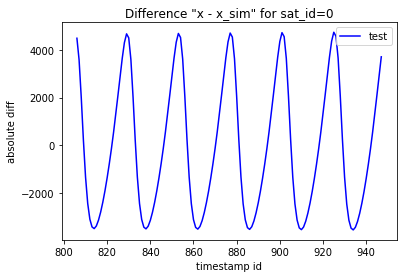

In [123]:
plot_eval(0, 'x', val, evaled, models)